<a href="https://colab.research.google.com/github/maxwillzq/algoTrading/blob/main/Portfolio_Optimization_Algo_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Optimization and Algorithmic Trading

In [15]:
! pip install pandas_datareader

In [22]:
! pip install quandl

In [2]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import logging
import numpy as np
%matplotlib inline
logger = logging.getLogger(__name__)

## Helper functions

In [51]:
def read_stock_data_to_df(stock_name, start = None, end = None):
  #Read Stock Data from Yahoo Finance
  if end is None:
    end = dt.datetime.now()
  logger.info(f"today is {end}")
  if not start:
    start = dt.datetime(end.year-2, end.month, end.day)
  df = web.DataReader(stock_name, 'yahoo', start, end)
  df.to_csv(stock_name + '.csv')
  df = pd.read_csv(stock_name + '.csv')
  return df

def draw_regular_plot(df, stock_name=None, param={}):
  plt.figure(figsize=(12,9))
  top = plt.subplot2grid((12,9), (0, 0), rowspan=10, colspan=9)
  bottom = plt.subplot2grid((12,9), (10,0), rowspan=2, colspan=9)
  top.plot(df.index, df['Adj Close'], color='blue') #df.index gives the dates
  bottom.bar(df.index, df['Volume'])
  # set the labels
  top.axes.get_xaxis().set_visible(False)
  if stock_name:
    top.set_title(stock_name)
  top.set_ylabel('Adj Close')
  bottom.set_ylabel('Volume')
  last = len(df)
  data_range_list = [90]
  if 'data_range_list' in param:
    data_range_list = param["data_range_list"]
  for data_range in data_range_list:
    rets = np.log(df['Adj Close'].iloc[last - data_range : last])
    x = df.index[last-data_range:last]
    slope, intercept, r_value, p_value, std_err = linregress(x, rets)
    print("Linear" + str(data_range) + " = " + str(slope))
    top.plot(x, np.e ** (intercept + slope*x), label="Linear" + str(data_range))
  legend = top.legend(loc='upper left', shadow=True, fontsize='x-large')

def draw_density_plot(df, param = {}):
  plt.figure(figsize=(12,9))
  ax = sns.distplot(df['Adj Close'].dropna(), bins=50, color='purple', vertical=True)
  rmin = min(df['Adj Close']) * 0.9
  rmax = max(df['Adj Close']) * 1.1
  step = param.get("step", 5)
  plt.yticks(np.arange(rmin, rmax, step))

def draw_moving_average_plot(df, param={}):
  # simple moving averages
  lists = [20, 50, 200]
  if "list" in param:
    lists = param["list"]
  args = {}
  for item in lists:
    df['MA' + str(item)] = df['Adj Close'].rolling(item).mean()
    args['MA' + str(item)] = df['MA' + str(item)]
  args['Adj Close'] = df['Adj Close']
  df2 = pd.DataFrame(args)
  df2.plot(figsize=(12, 9), legend=True, title=stock_name)
  #df2.to_csv('AAPL_MA.csv')
  fig = plt.gcf()
  fig.set_size_inches(12, 9)
  #fig.savefig('AAPL_plot.png', dpi=300)
  plt.show()
  print(df.tail())

def draw_price_to_ma_distance(df, stock_name, param={}):
  ma = 50
  if "MA" in param:
    ma = param["MA"]
  df['MA' + str(ma)] = df['Adj Close'].rolling(ma).mean()
  plt.plot(df.index, df['Adj Close'] - df['MA' + str(ma)])
  plt.title(f"{stock_name} Price - MA{ma}" )
  plt.show()

def indicator_1(df, param={}):
  """
  The discount rate if use MA price as baseline
  """
  MA = 50
  if 'MA' in param:
    MA = param['MA']
  result =  -(df['Adj Close'] - df['Adj Close'].rolling(MA).mean())/df['Adj Close'] * 100
  return result

from scipy.stats import linregress
def indicator_2(df,param={}):
  """
  The potential gain rate after 1 year use linear model
  """

  def momentum(closes):
      returns = np.log(closes)
      x = np.arange(len(returns))
      slope, _, rvalue, _, _ = linregress(x, returns)
      return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2
  
  MA = 90
  if 'MA' in param:
    MA = param['MA']
  result = (df.rolling(MA)['Adj Close'].apply(momentum, raw=False) - 1)
  #print("result = ", result)
  return result


## Stock data trend review

In [199]:
stock_name = "TSM"
end = dt.datetime.now()
start = dt.datetime(end.year - 1, end.month, end.day)
df = read_stock_data_to_df(stock_name, start=start, end=end)
print(df.describe())

             High         Low        Open       Close        Volume   Adj Close
count  252.000000  252.000000  252.000000  252.000000  2.520000e+02  252.000000
mean    73.160516   71.294246   72.236627   72.197143  9.846033e+06   71.478697
std     21.028595   20.358094   20.711903   20.611216  5.020874e+06   20.918292
min     45.180000   42.700001   43.740002   43.889999  3.172100e+06   43.158443
25%     54.672499   53.247500   54.182501   54.074999  6.827775e+06   52.775775
50%     67.605000   66.085003   67.244999   66.924999  8.597750e+06   66.301495
75%     87.894999   86.000002   87.022499   86.777502  1.126870e+07   86.412907
max    134.649994  123.209999  128.470001  126.449997  4.122680e+07  126.449997


252


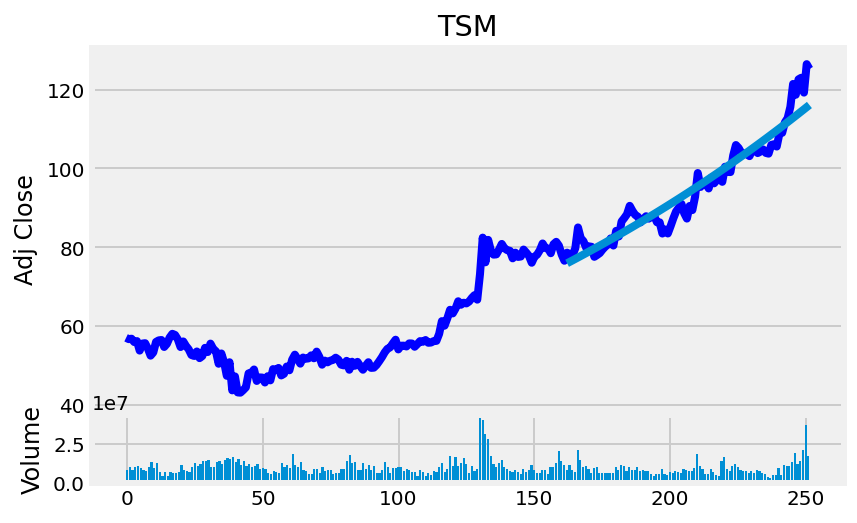

In [200]:
draw_regular_plot(df, stock_name)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


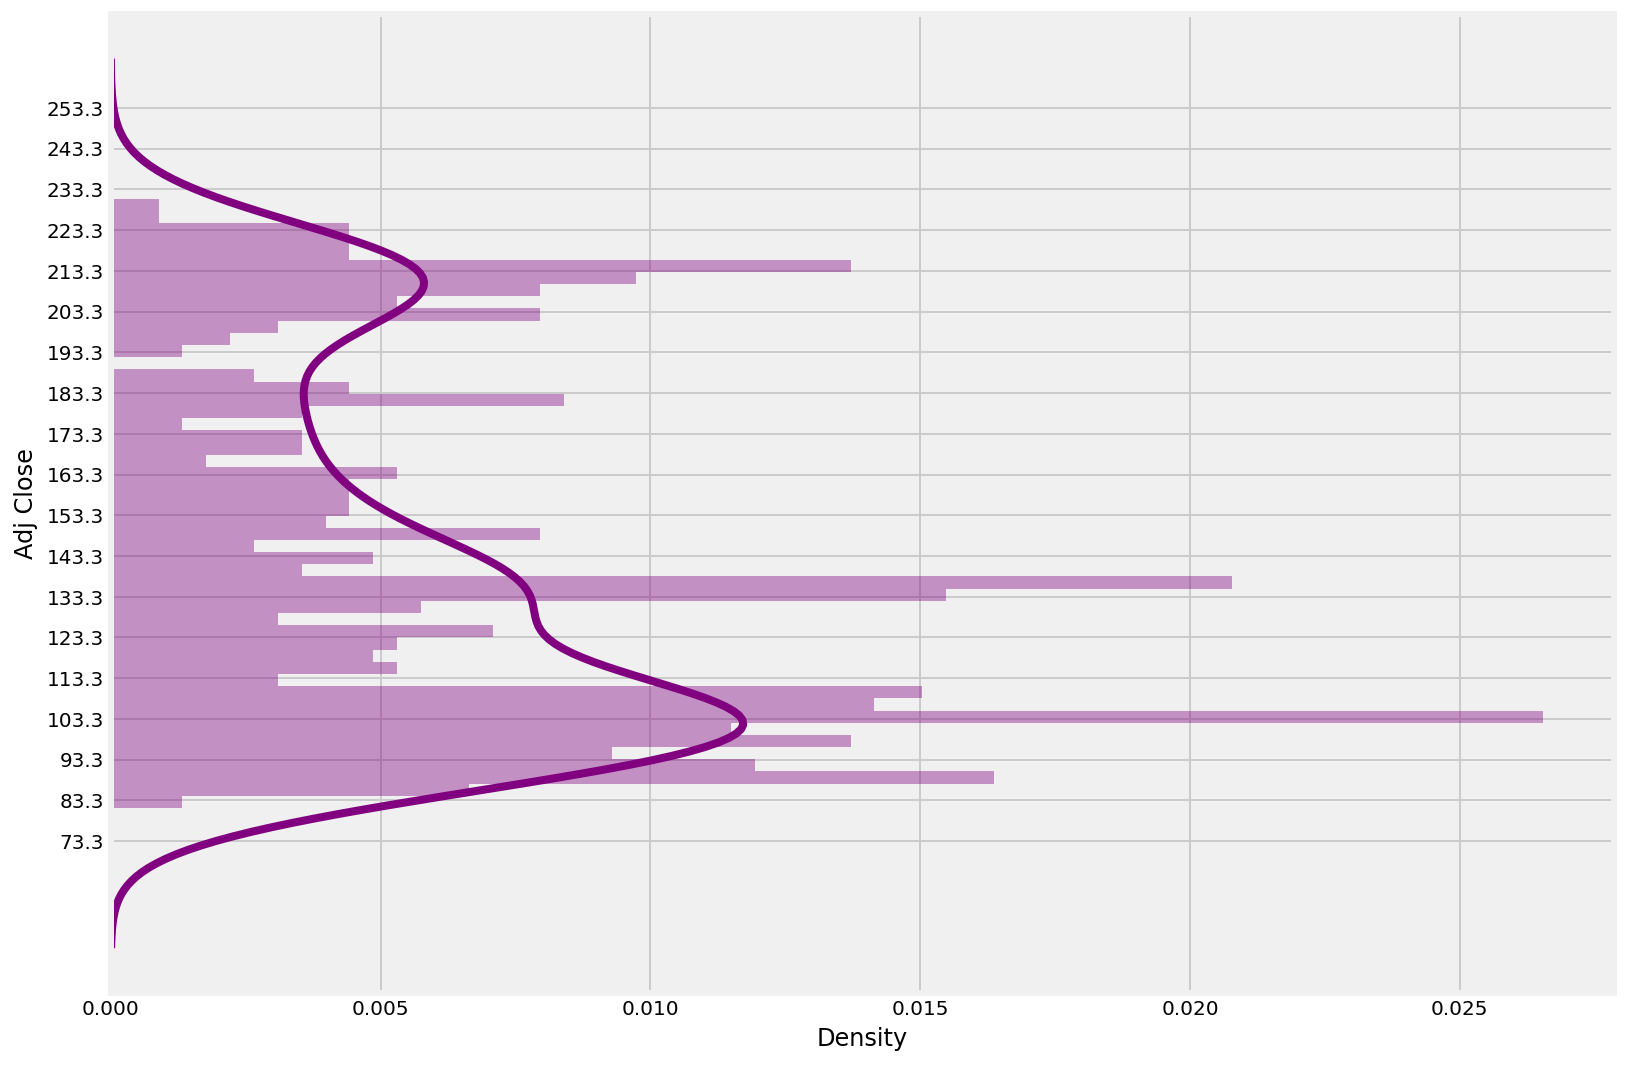

In [41]:
param = {}
param["step"] = 10
draw_density_plot(df, param)

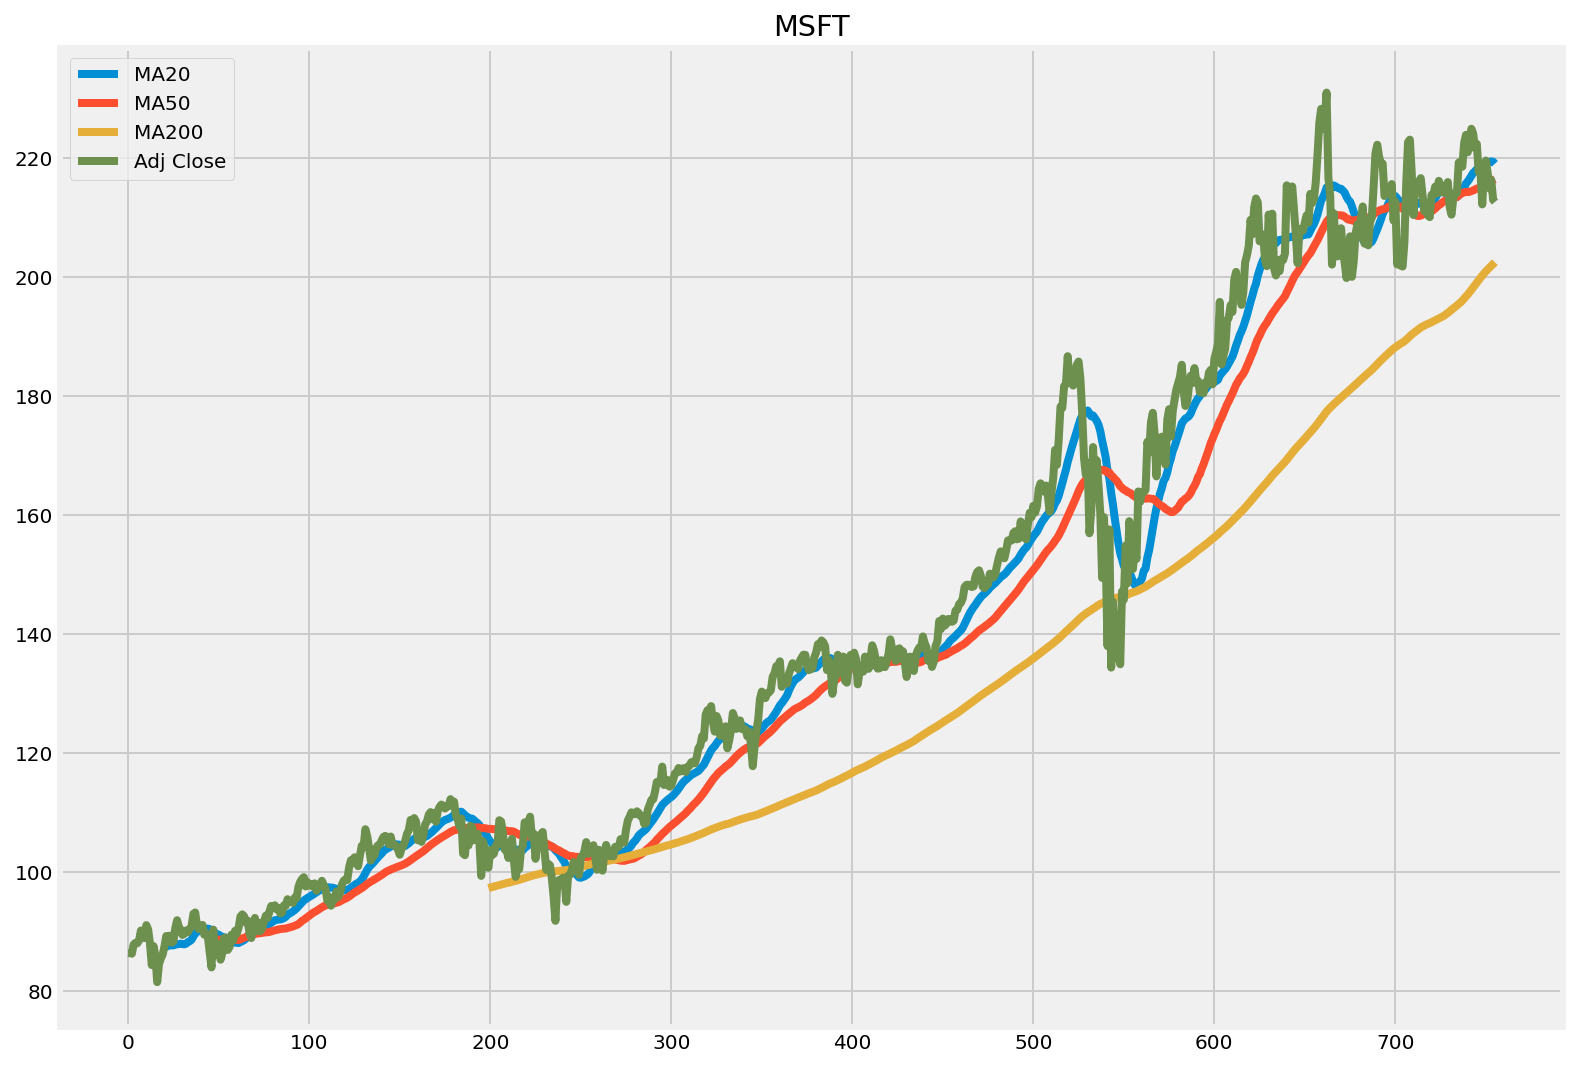

           Date        High         Low  ...        MA20        MA50       MA200
751  2021-01-11  218.910004  216.729996  ...  219.281499  215.611904  201.310884
752  2021-01-12  217.100006  213.320007  ...  219.364999  215.826795  201.642857
753  2021-01-13  216.759995  213.929993  ...  219.471999  216.114769  201.929640
754  2021-01-14  217.460007  212.740005  ...  219.416499  216.339135  202.212325
755  2021-01-15  214.509995  212.029999  ...  219.084998  216.474316  202.520941

[5 rows x 10 columns]


In [42]:
draw_moving_average_plot(df)

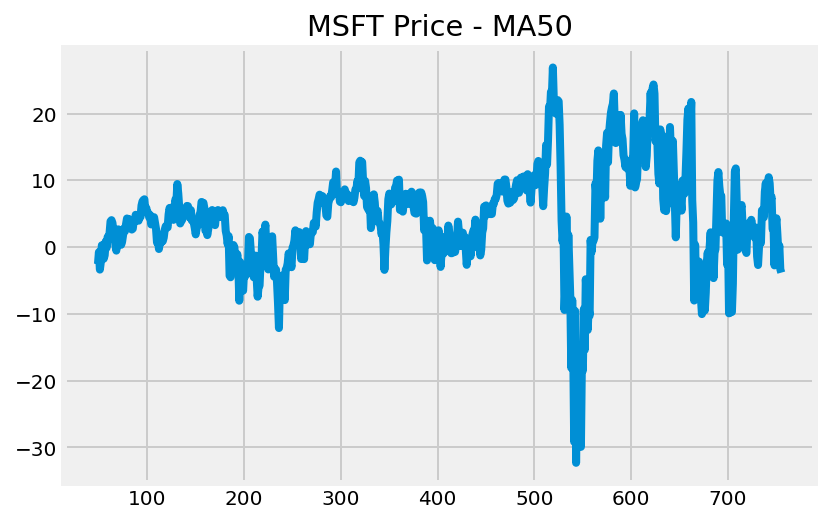

In [57]:
draw_price_to_ma_distance(df, stock_name, {'MA': 50})

# Select stock from stock table

Step 1: choose **stock**

         Date       High        Low  ...    Volume  Adj Close  indicator_1
0  2019-01-17  22.485001  22.020000  ...  12013700  22.139999          NaN
1  2019-01-18  23.850000  22.299999  ...  23275200  23.260000          NaN
2  2019-01-22  22.910000  21.500000  ...  19538300  21.680000          NaN
3  2019-01-23  22.600000  21.754999  ...  11262200  21.969999          NaN
4  2019-01-24  22.260000  21.500000  ...  13846300  22.100000          NaN

[5 rows x 8 columns]
         Date        High         Low  ...       Volume   Adj Close  indicator_1
0  2019-01-17  263.920013  259.959991  ...   96118400.0  253.342056          NaN
1  2019-01-18  266.980011  263.000000  ...  127900300.0  256.714050          NaN
2  2019-01-22  265.059998  261.059998  ...  115531200.0  253.245697          NaN
3  2019-01-23  264.790009  260.660004  ...   86030300.0  253.775589          NaN
4  2019-01-24  264.200012  262.079987  ...   59204100.0  253.910446          NaN

[5 rows x 8 columns]
         Date       

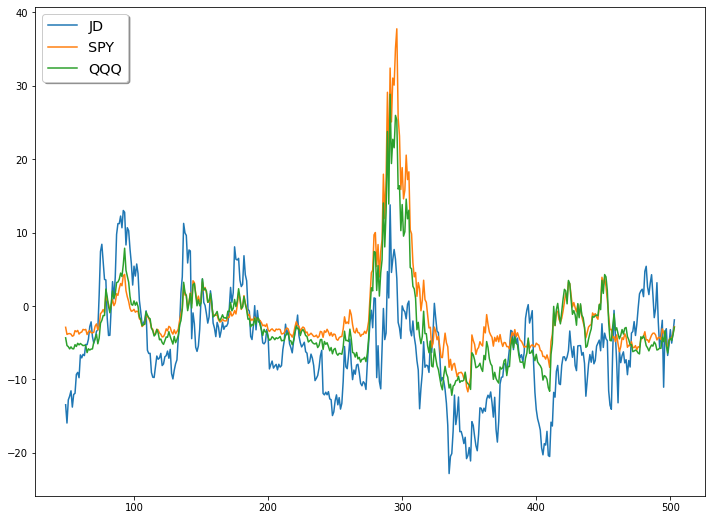

JD :indicator_2, -0.08663549616591926
SPY :indicator_2, 0.312646939178731
QQQ :indicator_2, 0.35854462753498706


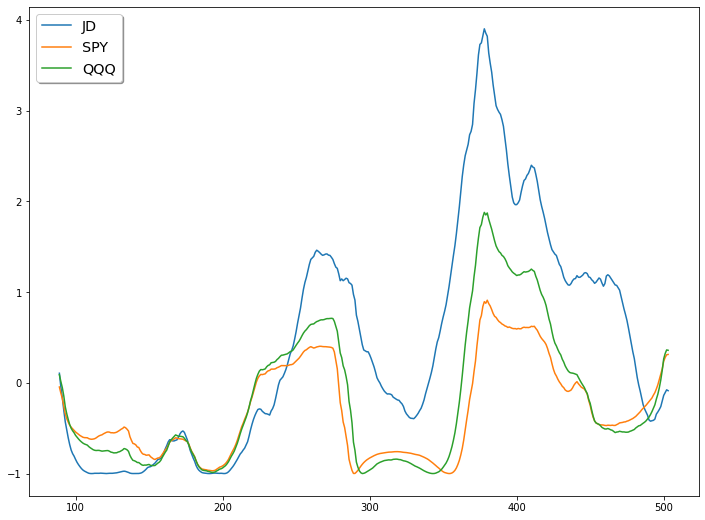

In [4]:
stock_name_list = ['JD', 'SPY', 'QQQ']
end = dt.datetime.now()
start = dt.datetime(end.year - 2, end.month, end.day)
result = {}
for stock_name in stock_name_list:
  df = read_stock_data_to_df(stock_name,start, end)
  df['indicator_1'] =  indicator_1(df)
  print(df.head())
  df['indicator_2'] =  indicator_2(df)
  result[stock_name] = df

fig, ax = plt.subplots(figsize=(12,9))
for stock_name in stock_name_list:
  ax.plot(result[stock_name]['indicator_1'], label=stock_name)
  print(stock_name, "indicator_1,",  result[stock_name]['indicator_1'].iloc[-1])
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()

fig, ax = plt.subplots(figsize=(12,9))
for stock_name in stock_name_list:
  ax.plot(result[stock_name]['indicator_2'], label=stock_name)
  print(stock_name, ":indicator_2,",  result[stock_name]['indicator_2'].iloc[-1])
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()


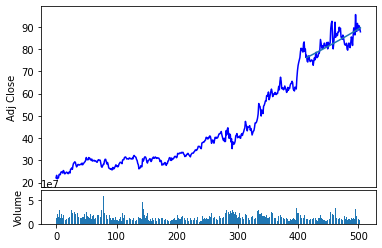

In [5]:
df = result['JD']
draw_regular_plot(df)

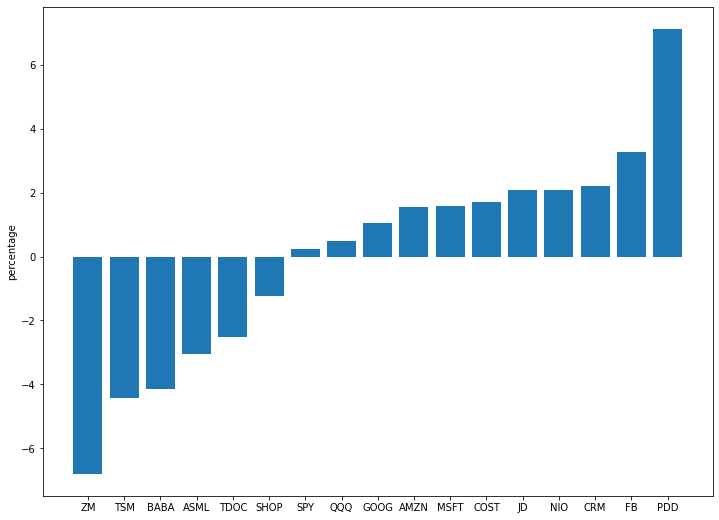

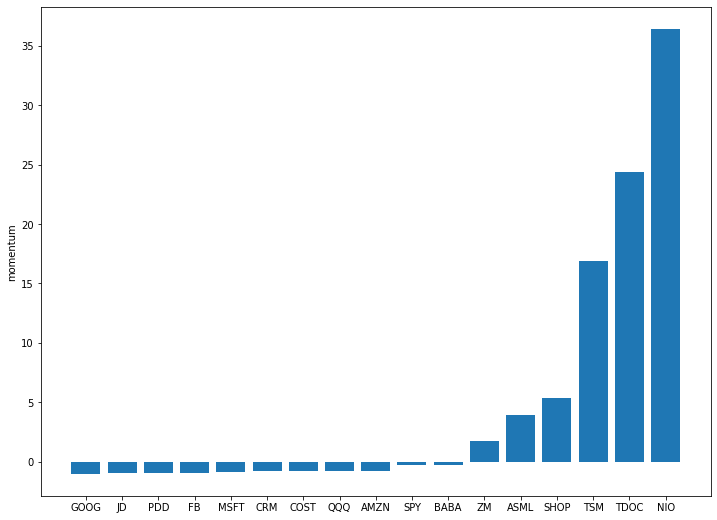

GOOG   -0.9999971554484278
JD   -0.9886508397618304
PDD   -0.9681626389536921
FB   -0.9463071707476319
MSFT   -0.8515219819614945
CRM   -0.7751331499510523
COST   -0.7542069986408634
QQQ   -0.7481873176125158
AMZN   -0.7475336246245747
SPY   -0.2963351093218598
BABA   -0.26728073303171307
ZM   1.7441390236995211
ASML   3.928007649626994
SHOP   5.372431441260279
TSM   16.90762129087048
TDOC   24.38190649739541
NIO   36.416739256957136


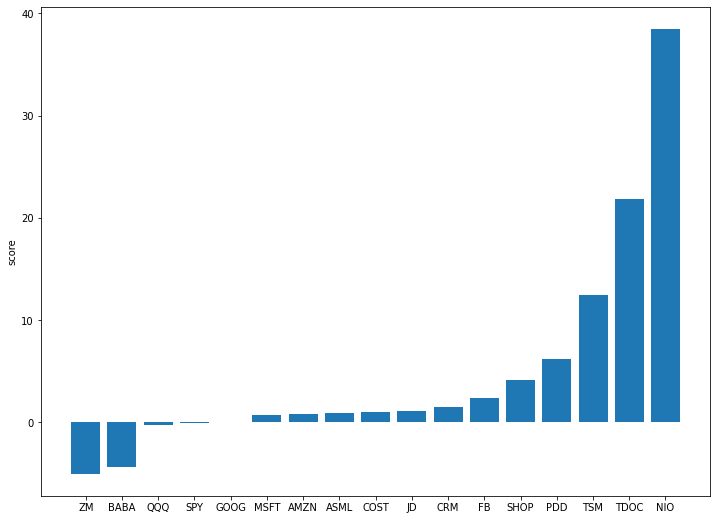

In [69]:
stock_name_list = ['TDOC', 'NIO', 'COST','SPY', 'QQQ', 'BABA', 'JD', 'PDD', 'FB', 'GOOG', 'MSFT', 'AMZN','TSM', 'ASML', 'CRM', 'SHOP', 'ZM']
end = dt.datetime.now()
start = dt.datetime(end.year - 3, end.month, end.day)
result = {}
for stock_name in stock_name_list:
  df = read_stock_data_to_df(stock_name,start, end)
  df['indicator_1'] =  indicator_1(df, {"MA": 10})
  df['indicator_2'] =  indicator_2(df, {"MA": 10})
  result[stock_name] = df

plt.figure(figsize=(12,9))
stock_name_list.sort(key=lambda x:result[x]['indicator_1'].iloc[-1])
plt.bar(range(len(stock_name_list)), [result[stock_name]['indicator_1'].iloc[-1] for stock_name in stock_name_list], align='center')
plt.xticks(range(len(stock_name_list)), stock_name_list)
plt.ylabel("percentage")
plt.show()

plt.figure(figsize=(12,9))
stock_name_list.sort(key=lambda x:result[x]['indicator_2'].iloc[-1])
plt.bar(range(len(stock_name_list)), [result[stock_name]['indicator_2'].iloc[-1] for stock_name in stock_name_list], align='center')
plt.xticks(range(len(stock_name_list)), stock_name_list)
plt.ylabel("momentum")
plt.show()

for stock_name in stock_name_list:
  print(stock_name, " ", result[stock_name]['indicator_2'].iloc[-1])


plt.figure(figsize=(12,9))
stock_name_list.sort(key=lambda x:result[x]['indicator_2'].iloc[-1] + result[x]['indicator_1'].iloc[-1] )
plt.bar(range(len(stock_name_list)), [result[stock_name]['indicator_2'].iloc[-1] + result[stock_name]['indicator_1'].iloc[-1] for stock_name in stock_name_list], align='center')
plt.xticks(range(len(stock_name_list)), stock_name_list)
plt.ylabel("score")
plt.show()


### Mid-term invest coice study (10  to 30 days)

Linear9 = 0.012009226493510475
Linear14 = 0.0050714657684196255
Linear30 = -0.005831627480446039
stock_name = ZM


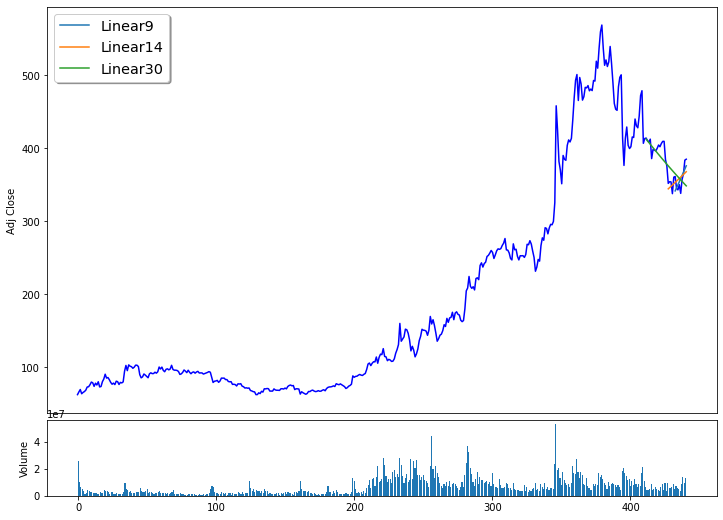

Linear9 = 0.004557688711433909
Linear14 = 0.002384887765817469
Linear30 = -0.005938789271195361
stock_name = BABA


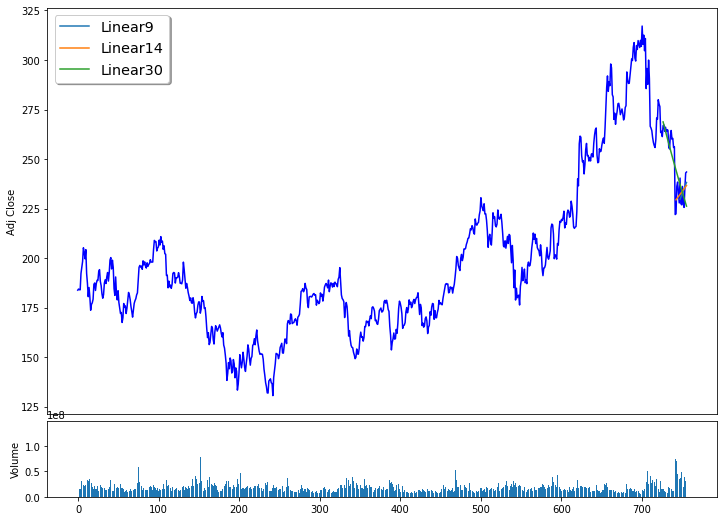

Linear9 = 0.000937964839650185
Linear14 = 0.000616493730386205
Linear30 = 0.0013883150621463586
stock_name = QQQ


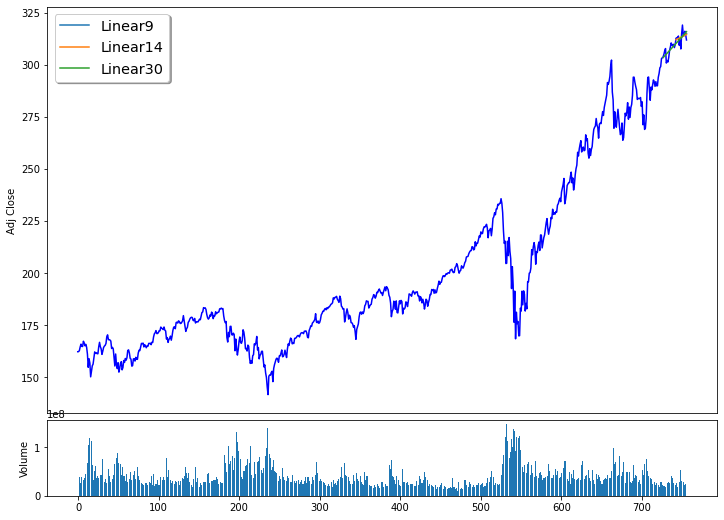

Linear9 = 0.0013843252657970893
Linear14 = 0.0018289664021210155
Linear30 = 0.001337642697803172
stock_name = SPY


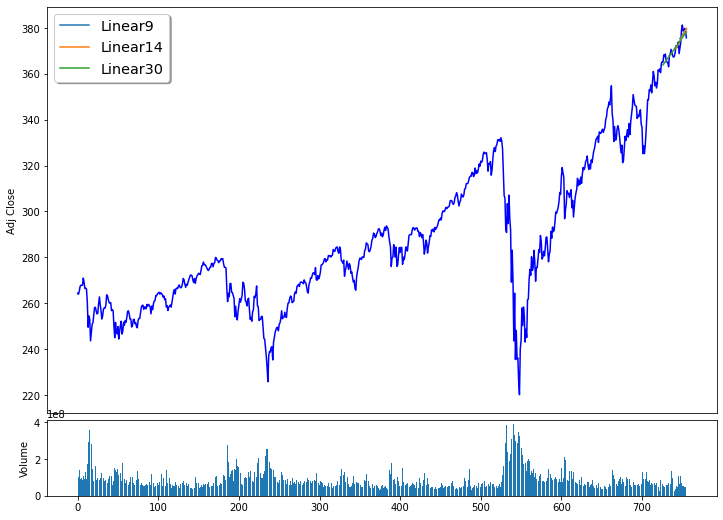

Linear9 = -0.001228082214578515
Linear14 = -0.00023054996229034924
Linear30 = -0.001086962028898982
stock_name = GOOG


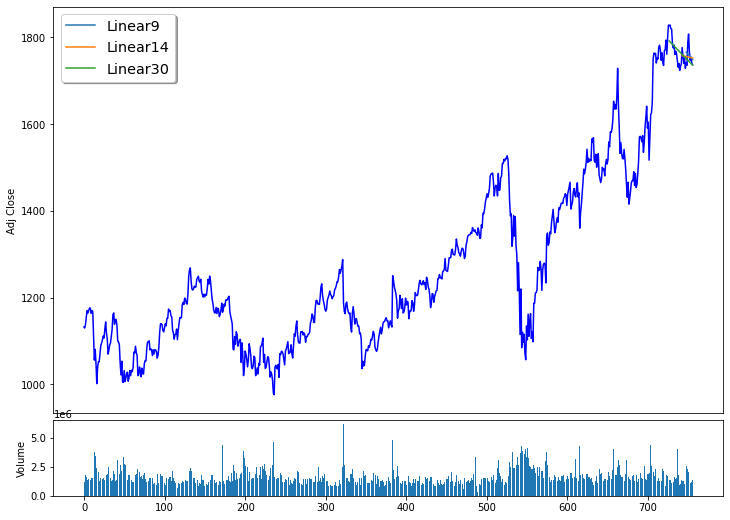

Linear9 = -0.0021037252555674347
Linear14 = -0.0037450235180442443
Linear30 = 0.00039620873151597025
stock_name = MSFT


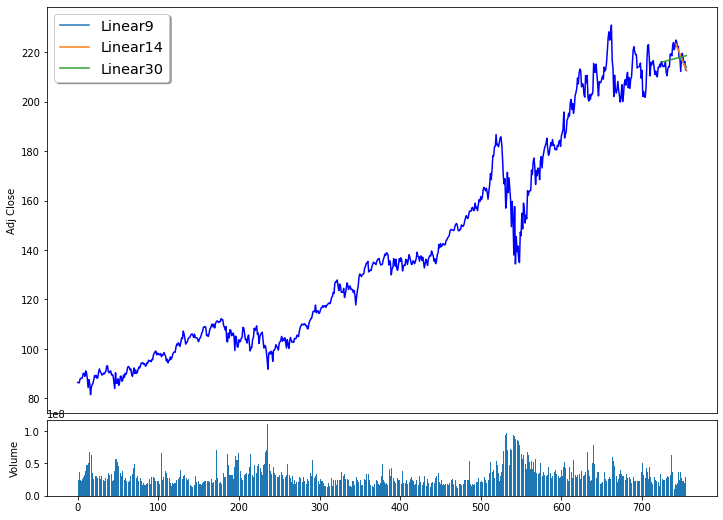

Linear9 = -0.002871761303039063
Linear14 = -0.004768930912721349
Linear30 = -3.960016765388222e-05
stock_name = AMZN


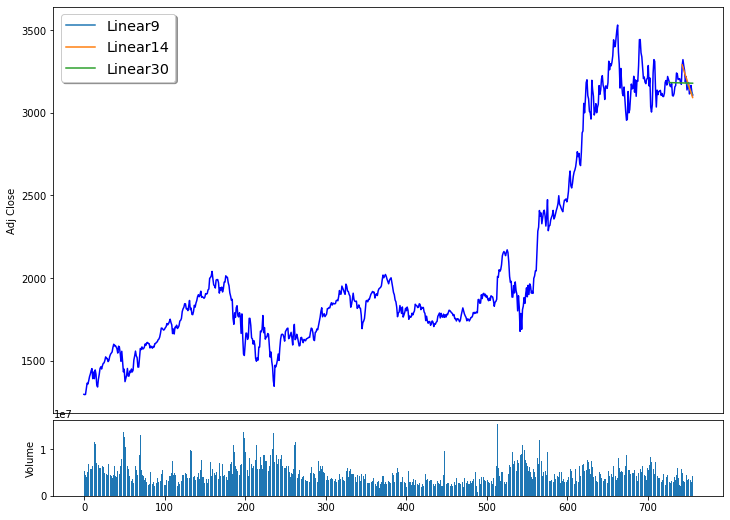

Linear9 = 0.0091213471467903
Linear14 = 0.007559560903186247
Linear30 = 0.005027004037161727
stock_name = ASML


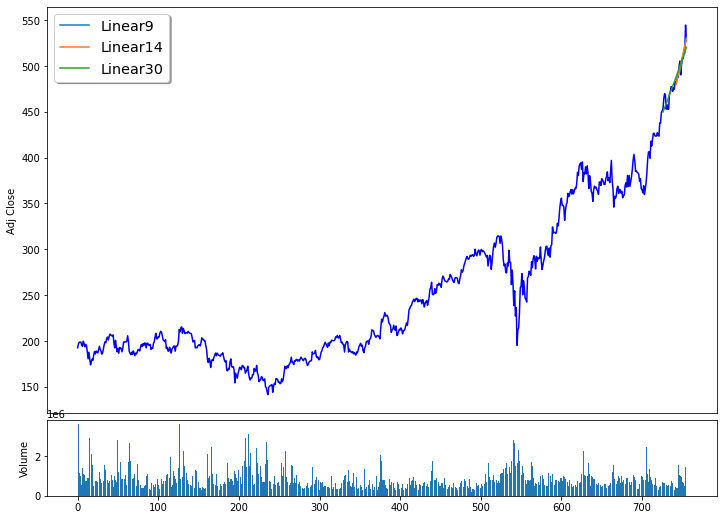

Linear9 = -0.0038500306985922443
Linear14 = -0.0028902872134280375
Linear30 = -0.0007374670210648799
stock_name = COST


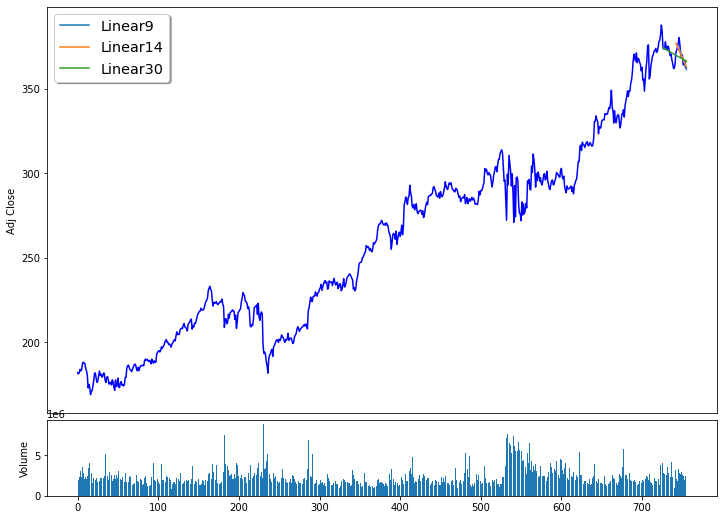

Linear9 = -0.004643024452048399
Linear14 = 0.0034657639343874734
Linear30 = 0.0037244452972397604
stock_name = JD


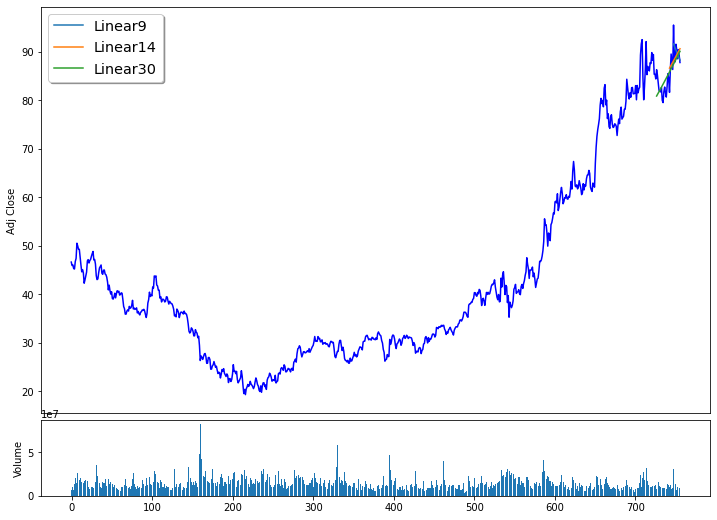

Linear9 = -0.003164457751643187
Linear14 = -0.0031992861260365002
Linear30 = -0.0013792093541187098
stock_name = CRM


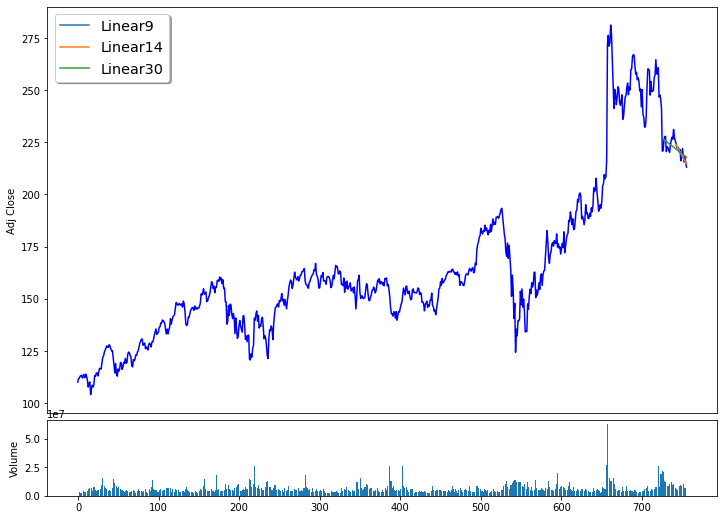

Linear9 = -0.011732370488294565
Linear14 = -0.009030572004606007
Linear30 = -0.003665097881517355
stock_name = FB


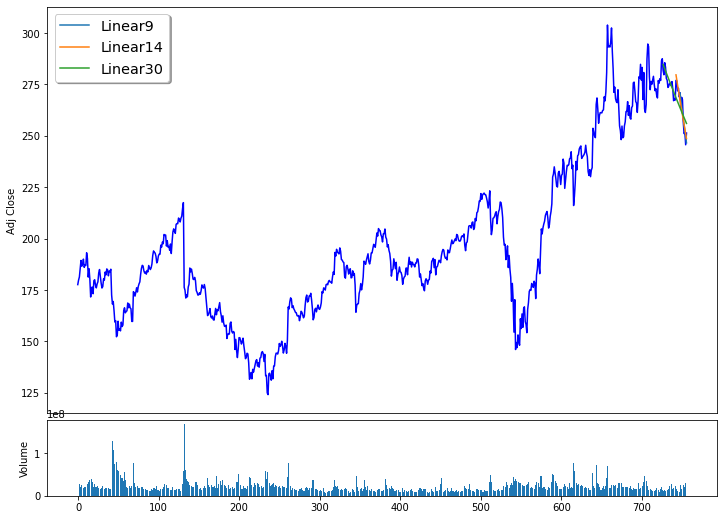

Linear9 = 0.008184561208830621
Linear14 = 0.0034576907256066223
Linear30 = 0.003515221063450587
stock_name = SHOP


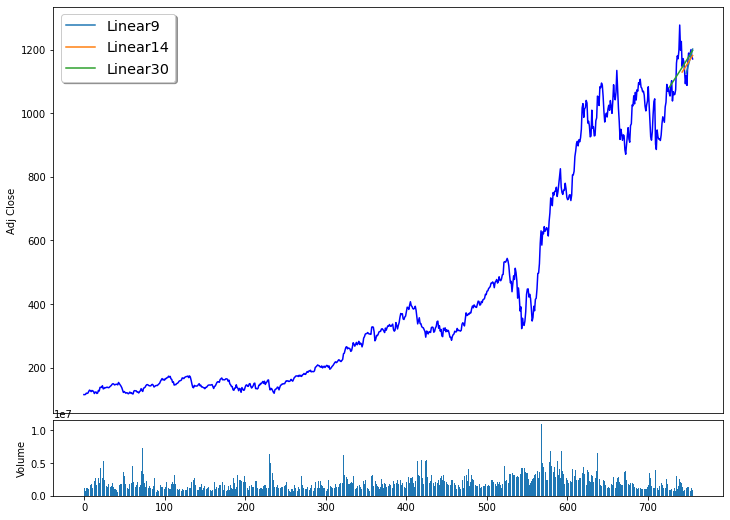

Linear9 = -0.01676598980221115
Linear14 = 0.0012265418213212268
Linear30 = 0.00730821884290204
stock_name = PDD


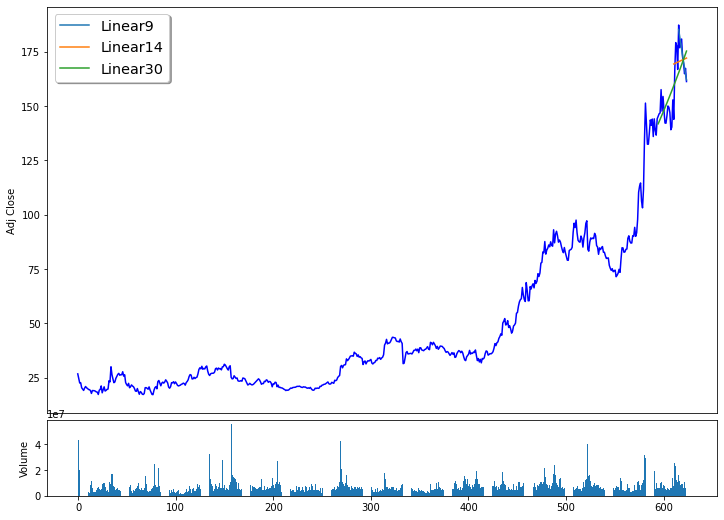

Linear9 = 0.0114530448532002
Linear14 = 0.014202626820448148
Linear30 = 0.007065624664842752
stock_name = TSM


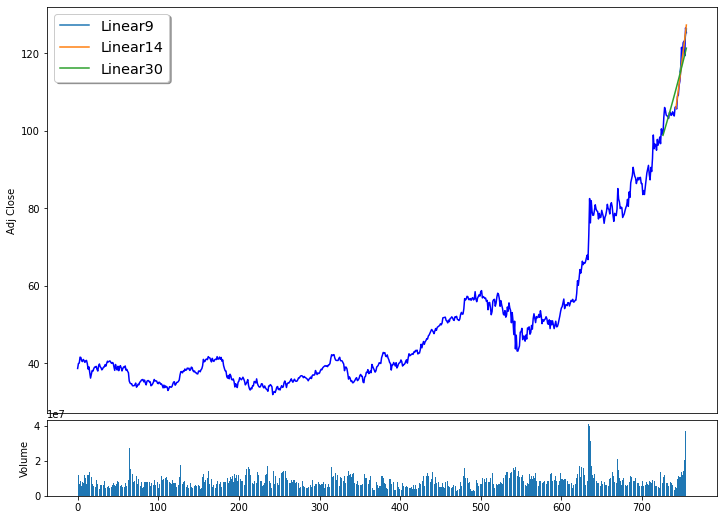

In [68]:
for stock_name in stock_name_list:
  draw_regular_plot(result[stock_name], param={"data_range_list": [7, 12, 26]})
  print(f"stock_name = {stock_name}")
  plt.show()
